In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "SPY.csv"
df = pd.read_csv(file_path)




# start to nov 2001 (dot com crash)
# not bad
# df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
# df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [4]:
print(df.tail())

            Date       Open       High        Low      Close     Volume  Day  \
4130  2009-06-23  67.457192  67.766315  66.989732  67.366714  188309800   23   
4131  2009-06-24  67.977433  68.671078  67.555209  67.947273  211577700   24   
4132  2009-06-25  67.607977  69.492888  67.532582  69.425034  279411000   25   
4133  2009-06-26  69.191295  69.545659  68.814313  69.244072  167579000   26   
4134  2009-06-29  69.447666  69.982980  69.063142  69.892502  168481300   29   

      Weekday  Week  Month  Year  
4130        1    26      6  2009  
4131        2    26      6  2009  
4132        3    26      6  2009  
4133        4    26      6  2009  
4134        0    27      6  2009  


In [5]:
# if 'Day' and 'Weekday' and 'Week' and 'Month' and 'Year' in df.columns:
    # df.drop(columns=['Day', 'Weekday', 'Week', 'Month', 'Year'], inplace=True)

In [6]:
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)


In [7]:
df = df.dropna()

In [8]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA


In [9]:
df = df.dropna()

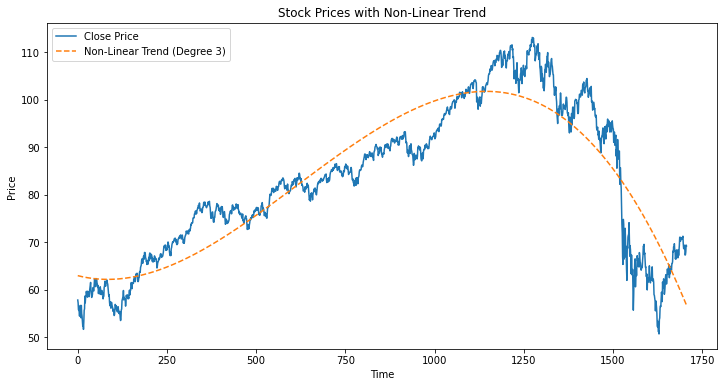

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming you have a DataFrame `df` with a 'Close' column

# Create an index for the time series (usually the row number)
df['Time'] = np.arange(len(df))

# Fit a polynomial regression to the 'Close' price
X = df[['Time']]  # Independent variable (time)
y = df['Close']   # Dependent variable (closing price)

# Initialize a polynomial features transformer (degree = 2 for quadratic, or higher for more non-linearity)
degree = 3  # You can change the degree for more complexity
poly = PolynomialFeatures(degree)

# Transform the Time feature into polynomial features
X_poly = poly.fit_transform(X)

# Initialize and fit the linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, y)

# Generate predictions for the polynomial regression (non-linear trend)
df['Non_Linear_Trend'] = model.predict(X_poly)

# Optionally, visualize the non-linear trend
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Close'], label='Close Price')
plt.plot(df['Time'], df['Non_Linear_Trend'], label=f'Non-Linear Trend (Degree {degree})', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Prices with Non-Linear Trend')
plt.legend()
plt.show()

## CREATING THE NEURAL NETWORK MODEL

In [11]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [13]:
# Define the LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, 1)
        out = self.sigmoid(out)
        return out

# Define a more complex LSTM-based model
# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         out = self.sigmoid(out)  # Apply sigmoid for binary classification
#         return out

# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         return out

class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


In [14]:

sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [15]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
# scaler = RobustScaler()
scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# scaler = StandardScaler()

# scaler.fit(X_train)
# X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)


# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1194, Val: 256, Test: 247


In [16]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0001
num_epochs = 500
patience = 30


# Initialize the LSTM model
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

model.to(device)

# Define loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
best_val_loss = float('inf')
early_stop_counter = 0

# if not os.path.exists("./models/best_lstm_model.pth"):
if not os.path.exists("./lstm_trials/lstm_after_gridsearch_new.pth"):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), "./lstm_trials/lstm_after_gridsearch_new.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

# Load the best model
# model.load_state_dict(torch.load("./lstm_trials/lstm_after_gridsearch_new.pth"))

# Evaluate on test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Calculate Mean Absolute Error (MAE)
test_mae = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        test_mae += mae.item() * X_batch.size(0)

test_mae /= len(test_loader.dataset)
print(f'Test MAE: {test_mae:.4f}')


Epoch 1/500, Train Loss: 6716.2907, Val Loss: 10676.0894
Epoch 2/500, Train Loss: 6733.6533, Val Loss: 10672.1448
Epoch 3/500, Train Loss: 6729.0223, Val Loss: 10665.5278
Epoch 4/500, Train Loss: 6716.1711, Val Loss: 10648.0190
Epoch 5/500, Train Loss: 6695.6040, Val Loss: 10584.1531
Epoch 6/500, Train Loss: 6640.5793, Val Loss: 10515.5542
Epoch 7/500, Train Loss: 6589.3972, Val Loss: 10445.7495
Epoch 8/500, Train Loss: 6535.5011, Val Loss: 10378.5623
Epoch 9/500, Train Loss: 6477.4454, Val Loss: 10310.0398
Epoch 10/500, Train Loss: 6423.9947, Val Loss: 10236.6492
Epoch 11/500, Train Loss: 6356.1059, Val Loss: 10160.5398
Epoch 12/500, Train Loss: 6304.2104, Val Loss: 10082.3093
Epoch 13/500, Train Loss: 6239.1700, Val Loss: 10001.6575
Epoch 14/500, Train Loss: 6172.3535, Val Loss: 9910.8835
Epoch 15/500, Train Loss: 6113.8303, Val Loss: 9814.2710
Epoch 16/500, Train Loss: 6036.5437, Val Loss: 9713.5840
Epoch 17/500, Train Loss: 5935.5610, Val Loss: 9608.6724
Epoch 18/500, Train Loss: 5

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [18]:
# X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)

# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_test, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_test)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")



In [19]:

# plt.figure(figsize=(12, 6))
# plt.plot(y_test, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

## Evaluating on entire dataset

In [20]:
# X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
# y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32).to(device)

# outputs = model(X_seq_tensor)


In [21]:
# error = 0
# largest_error = 0
# less_than_actual = 0
# more_than_actual = 0

# for true, pred in zip(y_seq, outputs):
#     percent = abs(true - pred) / true
#     if percent > largest_error:
#         largest_error = percent
#     error += percent
#     if pred < true:
#         less_than_actual += 1
#     else:
#         more_than_actual += 1

# error = error / len(y_seq)
# error = error.item()
# largest_error = largest_error.item()
# print(f"Average error percentage: {error*100}")
# print(f"Largest error percentage: {largest_error*100}")
# print(f"Less than actual: {less_than_actual}")
# print(f"More than actual: {more_than_actual}")


In [22]:
# train_cutoff = int(len(y_seq) * 0.7)
# val_cutoff = int(len(y_seq) * 0.85)

# plt.figure(figsize=(12, 6))
# plt.plot(y_seq, label='True Values')
# plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
# plt.axvline(x=train_cutoff, color='g', linestyle='--', label='Train/Val Split (80%)')
# plt.axvline(x=val_cutoff, color='b', linestyle='--', label='Val/Test Split (90%)')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('True vs Predicted Values')
# plt.legend()
# plt.show()

In [23]:
# outputs

In [24]:
# df['Target_Higher_Lower'] = np.where(df['Target'] > df['Open'], 'higher', 'lower')

In [25]:
# # Ensure outputs is detached from the computation graph and converted to numpy
# predicted_values = outputs.cpu().detach().numpy()

# # Add the predicted values as a new column in the dataframe
# df['Predicted'] = np.nan
# df.loc[df.index[-len(predicted_values):], 'Predicted'] = predicted_values

# print(df[['Date', 'Target', 'Predicted']].tail())

In [26]:
new_df = df.dropna()

In [27]:
# new_df['Predicted_Higher_Lower'] = np.where(new_df['Predicted'] > new_df['Open'], 'higher', 'lower')
# new_df['Correct'] = np.where(new_df['Predicted_Higher_Lower'] == new_df['Target_Higher_Lower'], 1, 0)

# print('number of correct predictions:', new_df['Correct'].sum())


===== Trial 1 =====
Epoch 1/500, Train Loss: 6763.2772, Val Loss: 10713.6035
Epoch 2/500, Train Loss: 6758.6477, Val Loss: 10701.5747
Epoch 3/500, Train Loss: 6739.0467, Val Loss: 10670.2893
Epoch 4/500, Train Loss: 6716.1372, Val Loss: 10561.9910
Epoch 5/500, Train Loss: 6613.6149, Val Loss: 10402.7319
Epoch 6/500, Train Loss: 6471.3855, Val Loss: 10241.1726
Epoch 7/500, Train Loss: 6340.3080, Val Loss: 10081.0510
Epoch 8/500, Train Loss: 6203.6837, Val Loss: 9919.1099
Epoch 9/500, Train Loss: 6073.1558, Val Loss: 9737.1287
Epoch 10/500, Train Loss: 5929.2391, Val Loss: 9537.0137
Epoch 11/500, Train Loss: 5764.2864, Val Loss: 9321.2063
Epoch 12/500, Train Loss: 5596.2526, Val Loss: 9093.7020
Epoch 13/500, Train Loss: 5411.0915, Val Loss: 8853.5216
Epoch 14/500, Train Loss: 5215.2950, Val Loss: 8571.6503
Epoch 15/500, Train Loss: 4985.6194, Val Loss: 8265.6633
Epoch 16/500, Train Loss: 4786.4053, Val Loss: 7950.4655
Epoch 17/500, Train Loss: 4527.7063, Val Loss: 7627.2079
Epoch 18/500

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 6772.9840, Val Loss: 10744.6392
Epoch 2/500, Train Loss: 6775.0015, Val Loss: 10737.0889
Epoch 3/500, Train Loss: 6792.5376, Val Loss: 10725.0916
Epoch 4/500, Train Loss: 6760.1792, Val Loss: 10677.0994
Epoch 5/500, Train Loss: 6711.8312, Val Loss: 10583.4871
Epoch 6/500, Train Loss: 6627.1954, Val Loss: 10486.0781
Epoch 7/500, Train Loss: 6554.0673, Val Loss: 10386.3965
Epoch 8/500, Train Loss: 6474.4542, Val Loss: 10285.3882
Epoch 9/500, Train Loss: 6392.3129, Val Loss: 10182.5247
Epoch 10/500, Train Loss: 6309.5294, Val Loss: 10075.8027
Epoch 11/500, Train Loss: 6219.9969, Val Loss: 9962.1426
Epoch 12/500, Train Loss: 6132.6048, Val Loss: 9836.7739
Epoch 13/500, Train Loss: 6026.5513, Val Loss: 9699.7263
Epoch 14/500, Train Loss: 5921.6213, Val Loss: 9553.5906
Epoch 15/500, Train Loss: 5810.1247, Val Loss: 9399.0566
Epoch 16/500, Train Loss: 5675.5417, Val Loss: 9236.6592
Epoch 17/500, Train Loss: 5550.8681, Val Loss: 9066.7896
Epoch 18/500, Train Loss: 5419

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 6758.1467, Val Loss: 10707.8833
Epoch 2/500, Train Loss: 6755.3845, Val Loss: 10694.0054
Epoch 3/500, Train Loss: 6729.6106, Val Loss: 10650.9626
Epoch 4/500, Train Loss: 6691.6723, Val Loss: 10494.2817
Epoch 5/500, Train Loss: 6551.3268, Val Loss: 10297.7268
Epoch 6/500, Train Loss: 6367.8206, Val Loss: 10094.1409
Epoch 7/500, Train Loss: 6211.9278, Val Loss: 9897.6179
Epoch 8/500, Train Loss: 6051.5983, Val Loss: 9693.9009
Epoch 9/500, Train Loss: 5904.9510, Val Loss: 9483.8547
Epoch 10/500, Train Loss: 5726.7332, Val Loss: 9266.5417
Epoch 11/500, Train Loss: 5565.8953, Val Loss: 9039.0615
Epoch 12/500, Train Loss: 5367.8453, Val Loss: 8792.1219
Epoch 13/500, Train Loss: 5172.2382, Val Loss: 8531.4487
Epoch 14/500, Train Loss: 4975.6996, Val Loss: 8257.7279
Epoch 15/500, Train Loss: 4785.6536, Val Loss: 7973.5680
Epoch 16/500, Train Loss: 4547.1460, Val Loss: 7679.4871
Epoch 17/500, Train Loss: 4328.5010, Val Loss: 7375.7936
Epoch 18/500, Train Loss: 4089.841

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 31.7476
Test MAE: 4.2980
Average error percentage: 4.41%
Largest error percentage: 24.32%

===== Trial 5 =====
Epoch 1/500, Train Loss: 6749.2722, Val Loss: 10707.9041
Epoch 2/500, Train Loss: 6751.5303, Val Loss: 10698.2036
Epoch 3/500, Train Loss: 6744.6929, Val Loss: 10673.4863
Epoch 4/500, Train Loss: 6708.4851, Val Loss: 10565.1013
Epoch 5/500, Train Loss: 6614.4734, Val Loss: 10410.6948
Epoch 6/500, Train Loss: 6475.6972, Val Loss: 10245.2556
Epoch 7/500, Train Loss: 6327.8538, Val Loss: 10073.4424
Epoch 8/500, Train Loss: 6195.8749, Val Loss: 9894.5745
Epoch 9/500, Train Loss: 6049.1426, Val Loss: 9705.2236
Epoch 10/500, Train Loss: 5914.2625, Val Loss: 9500.1709
Epoch 11/500, Train Loss: 5752.0253, Val Loss: 9281.8621
Epoch 12/500, Train Loss: 5566.3937, Val Loss: 9050.9176
Epoch 13/500, Train Loss: 5375.9382, Val Loss: 8807.7665
Epoch 14/500, Train Loss: 5190.8216, Val Loss: 8554.1777
Epoch 15/500, Train Loss: 4996.1503, Val Loss: 8289.2468
Epoch 16/500, Train Loss:

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



===== Trial 6 =====
Epoch 1/500, Train Loss: 6775.1834, Val Loss: 10738.1033
Epoch 2/500, Train Loss: 6775.5331, Val Loss: 10728.6321
Epoch 3/500, Train Loss: 6763.0783, Val Loss: 10718.5422
Epoch 4/500, Train Loss: 6752.4001, Val Loss: 10685.0378
Epoch 5/500, Train Loss: 6714.7664, Val Loss: 10602.5278
Epoch 6/500, Train Loss: 6627.1897, Val Loss: 10483.1675
Epoch 7/500, Train Loss: 6546.1181, Val Loss: 10349.8855
Epoch 8/500, Train Loss: 6419.0097, Val Loss: 10216.7988
Epoch 9/500, Train Loss: 6320.3377, Val Loss: 10073.4089
Epoch 10/500, Train Loss: 6194.5183, Val Loss: 9925.9700
Epoch 11/500, Train Loss: 6092.1830, Val Loss: 9771.3953
Epoch 12/500, Train Loss: 5957.3453, Val Loss: 9601.4797
Epoch 13/500, Train Loss: 5823.7085, Val Loss: 9411.9353
Epoch 14/500, Train Loss: 5677.3176, Val Loss: 9208.1233
Epoch 15/500, Train Loss: 5525.3965, Val Loss: 8993.6548
Epoch 16/500, Train Loss: 5345.9463, Val Loss: 8769.0365
Epoch 17/500, Train Loss: 5184.3593, Val Loss: 8533.6782
Epoch 18/5

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 6731.7047, Val Loss: 10680.6387
Epoch 2/500, Train Loss: 6727.5110, Val Loss: 10670.4104
Epoch 3/500, Train Loss: 6725.9567, Val Loss: 10651.2170
Epoch 4/500, Train Loss: 6694.9100, Val Loss: 10573.5969
Epoch 5/500, Train Loss: 6612.2107, Val Loss: 10416.1509
Epoch 6/500, Train Loss: 6483.5393, Val Loss: 10257.4375
Epoch 7/500, Train Loss: 6348.3198, Val Loss: 10094.5347
Epoch 8/500, Train Loss: 6211.4562, Val Loss: 9924.7786
Epoch 9/500, Train Loss: 6080.0242, Val Loss: 9748.7910
Epoch 10/500, Train Loss: 5943.3997, Val Loss: 9564.5505
Epoch 11/500, Train Loss: 5805.1788, Val Loss: 9372.3911
Epoch 12/500, Train Loss: 5650.5662, Val Loss: 9172.4497
Epoch 13/500, Train Loss: 5487.8779, Val Loss: 8962.9392
Epoch 14/500, Train Loss: 5321.0363, Val Loss: 8743.1641
Epoch 15/500, Train Loss: 5133.8794, Val Loss: 8497.7601
Epoch 16/500, Train Loss: 4954.9184, Val Loss: 8241.0175
Epoch 17/500, Train Loss: 4760.4565, Val Loss: 7974.8091
Epoch 18/500, Train Loss: 4574.85

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



===== Trial 8 =====
Epoch 1/500, Train Loss: 6760.7862, Val Loss: 10713.1360
Epoch 2/500, Train Loss: 6770.4184, Val Loss: 10701.5469
Epoch 3/500, Train Loss: 6745.6484, Val Loss: 10671.9329
Epoch 4/500, Train Loss: 6697.7561, Val Loss: 10540.1533
Epoch 5/500, Train Loss: 6572.5136, Val Loss: 10345.7417
Epoch 6/500, Train Loss: 6422.9155, Val Loss: 10142.6113
Epoch 7/500, Train Loss: 6238.2668, Val Loss: 9925.2656
Epoch 8/500, Train Loss: 6064.6177, Val Loss: 9680.6799
Epoch 9/500, Train Loss: 5862.9250, Val Loss: 9427.5566
Epoch 10/500, Train Loss: 5654.8309, Val Loss: 9163.8374
Epoch 11/500, Train Loss: 5456.4759, Val Loss: 8884.4493
Epoch 12/500, Train Loss: 5238.0560, Val Loss: 8589.0089
Epoch 13/500, Train Loss: 5012.6025, Val Loss: 8278.1049
Epoch 14/500, Train Loss: 4773.4438, Val Loss: 7953.6215
Epoch 15/500, Train Loss: 4532.8846, Val Loss: 7616.6915
Epoch 16/500, Train Loss: 4272.4468, Val Loss: 7266.5712
Epoch 17/500, Train Loss: 3997.2275, Val Loss: 6900.6425
Epoch 18/500,

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 6767.4775, Val Loss: 10719.6914
Epoch 2/500, Train Loss: 6757.6750, Val Loss: 10707.1069
Epoch 3/500, Train Loss: 6751.0357, Val Loss: 10667.7346
Epoch 4/500, Train Loss: 6696.8042, Val Loss: 10547.8384
Epoch 5/500, Train Loss: 6587.7913, Val Loss: 10384.9167
Epoch 6/500, Train Loss: 6439.8756, Val Loss: 10203.9849
Epoch 7/500, Train Loss: 6303.7556, Val Loss: 10018.8633
Epoch 8/500, Train Loss: 6146.5362, Val Loss: 9829.7729
Epoch 9/500, Train Loss: 6005.1220, Val Loss: 9633.7754
Epoch 10/500, Train Loss: 5849.2231, Val Loss: 9428.2583
Epoch 11/500, Train Loss: 5687.2514, Val Loss: 9205.9609
Epoch 12/500, Train Loss: 5506.5614, Val Loss: 8960.5408
Epoch 13/500, Train Loss: 5328.1490, Val Loss: 8705.4364
Epoch 14/500, Train Loss: 5107.4363, Val Loss: 8440.8000
Epoch 15/500, Train Loss: 4908.8606, Val Loss: 8166.6531
Epoch 16/500, Train Loss: 4707.0111, Val Loss: 7883.3721
Epoch 17/500, Train Loss: 4475.0987, Val Loss: 7591.2826
Epoch 18/500, Train Loss: 4263.92

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/500, Train Loss: 6775.7962, Val Loss: 10726.0117
Epoch 2/500, Train Loss: 6774.9763, Val Loss: 10712.4458
Epoch 3/500, Train Loss: 6762.2224, Val Loss: 10677.6455
Epoch 4/500, Train Loss: 6705.9272, Val Loss: 10549.8794
Epoch 5/500, Train Loss: 6598.4364, Val Loss: 10358.1387
Epoch 6/500, Train Loss: 6439.3170, Val Loss: 10167.6758
Epoch 7/500, Train Loss: 6276.9799, Val Loss: 9986.3982
Epoch 8/500, Train Loss: 6120.7225, Val Loss: 9806.5183
Epoch 9/500, Train Loss: 5977.9153, Val Loss: 9620.0659
Epoch 10/500, Train Loss: 5833.9118, Val Loss: 9424.0791
Epoch 11/500, Train Loss: 5681.6795, Val Loss: 9211.2334
Epoch 12/500, Train Loss: 5512.7889, Val Loss: 8987.4014
Epoch 13/500, Train Loss: 5346.9313, Val Loss: 8753.4757
Epoch 14/500, Train Loss: 5166.9017, Val Loss: 8509.2844
Epoch 15/500, Train Loss: 4959.3023, Val Loss: 8254.5051
Epoch 16/500, Train Loss: 4766.0381, Val Loss: 7989.3826
Epoch 17/500, Train Loss: 4573.0683, Val Loss: 7714.1351
Epoch 18/500, Train Loss: 4377.847

d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Anaconda\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 31.6978
Test MAE: 4.4801
Average error percentage: 4.74%
Largest error percentage: 19.18%


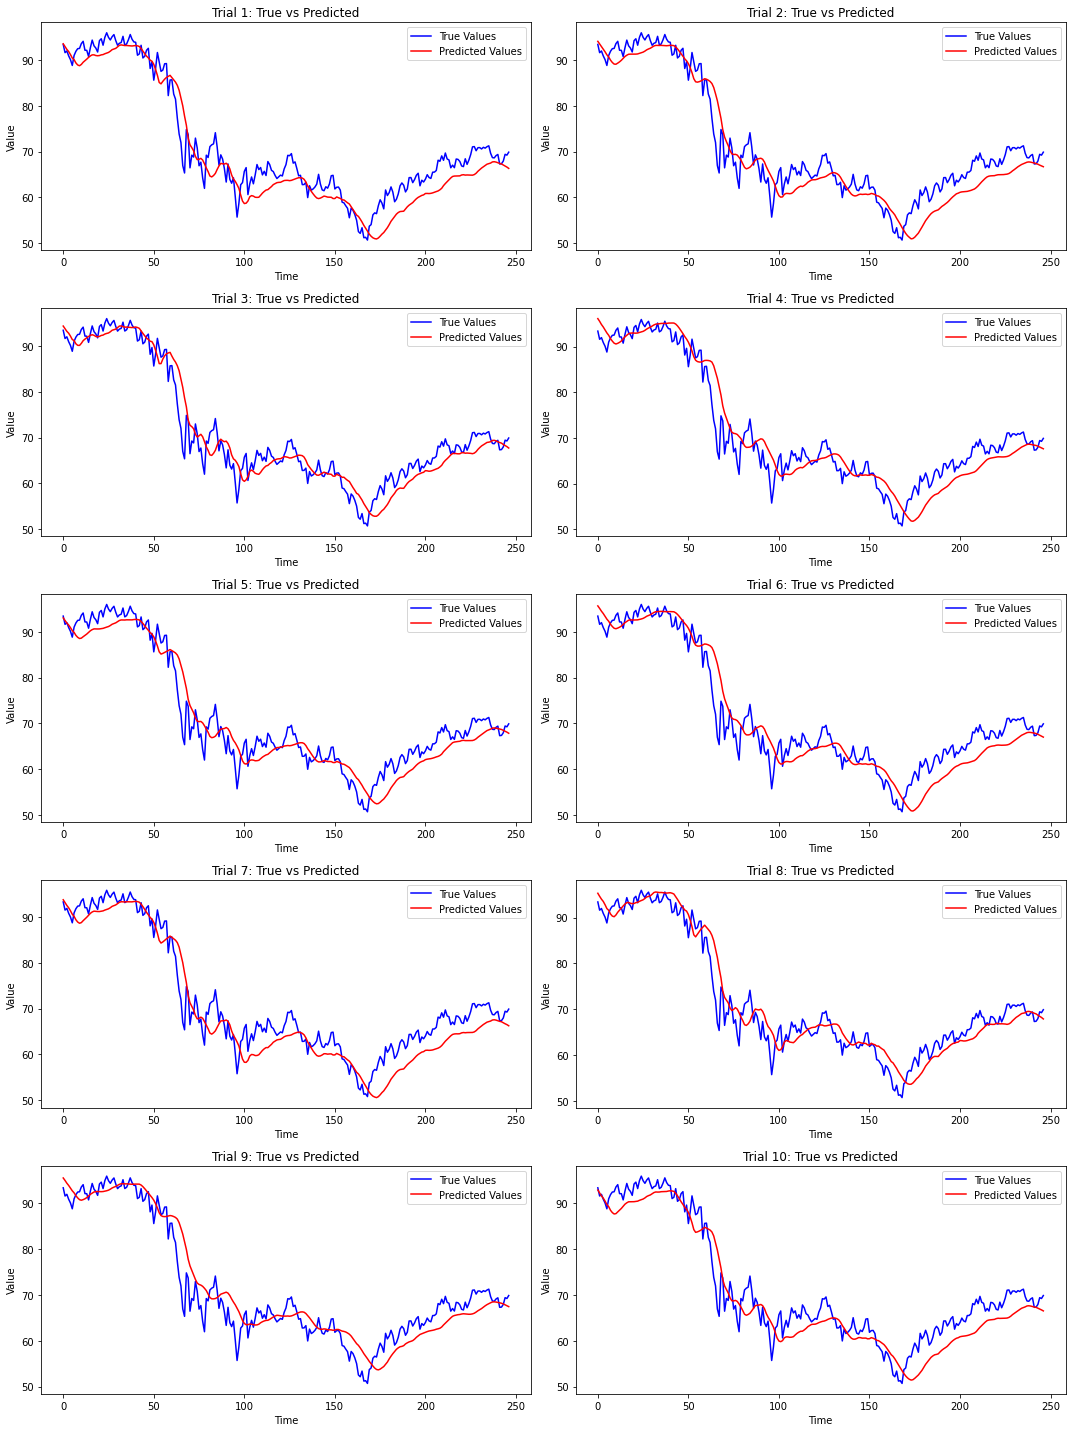


===== Final Results Across 10 Trials =====
Average Validation Loss: 6.8440 ± 1.3983
Average Test Loss: 30.5317 ± 2.2530
Average MAE: 4.2761 ± 0.2144
Average Error Percentage: 4.38% ± 0.41%
Largest Error Percentage: 21.67% ± 2.03%


In [28]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.0001
num_epochs = 500
patience = 30
num_trials = 10  # Number of runs

# Store results
results = {
    "val_loss": [],
    "test_loss": [],
    "mae": [],
    "avg_error_percent": [],
    "largest_error_percent": []
}

# Multi-plot setup
fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns

for trial in range(num_trials):
    print(f"\n===== Trial {trial+1} =====")
    
    # Initialize model
    model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate).to(device)

    # Define loss and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with early stopping
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    test_loss /= len(test_loader.dataset)

    # Calculate Mean Absolute Error (MAE)
    test_mae = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mae = torch.mean(torch.abs(outputs - y_batch))
            test_mae += mae.item() * X_batch.size(0)

    test_mae /= len(test_loader.dataset)

    # Compute error percentages
    X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    outputs = model(X_seq_tensor).cpu().detach().numpy()

    error = 0
    largest_error = 0
    less_than_actual = 0
    more_than_actual = 0

    for true, pred in zip(y_test, outputs):
        percent = abs(true - pred) / true
        if percent > largest_error:
            largest_error = percent
        error += percent
        if pred < true:
            less_than_actual += 1
        else:
            more_than_actual += 1

    avg_error = (error / len(y_test)).item()
    largest_error = largest_error.item()

    # Store results
    results["val_loss"].append(val_loss)
    results["test_loss"].append(test_loss)
    results["mae"].append(test_mae)
    results["avg_error_percent"].append(avg_error * 100)
    results["largest_error_percent"].append(largest_error * 100)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Average error percentage: {avg_error * 100:.2f}%")
    print(f"Largest error percentage: {largest_error * 100:.2f}%")

    # Plot predictions
    ax = axes[trial // 2, trial % 2]
    ax.plot(y_test, label='True Values', color='blue')
    ax.plot(outputs, label='Predicted Values', color='red')
    ax.set_title(f'Trial {trial + 1}: True vs Predicted')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()

# Display all subplots
plt.tight_layout()
plt.show()

# Print final average results
print("\n===== Final Results Across 10 Trials =====")
print(f"Average Validation Loss: {np.mean(results['val_loss']):.4f} ± {np.std(results['val_loss']):.4f}")
print(f"Average Test Loss: {np.mean(results['test_loss']):.4f} ± {np.std(results['test_loss']):.4f}")
print(f"Average MAE: {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
print(f"Average Error Percentage: {np.mean(results['avg_error_percent']):.2f}% ± {np.std(results['avg_error_percent']):.2f}%")
print(f"Largest Error Percentage: {np.mean(results['largest_error_percent']):.2f}% ± {np.std(results['largest_error_percent']):.2f}%")
